## Import Libraries

In [12]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os
from scipy.ndimage.measurements import label

import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

from ipywidgets import FloatProgress
from IPython.display import display

from tqdm import tqdm_notebook as tqdm

from collections import namedtuple


% matplotlib inline

ImportError: No module named 'Image'

# Part 1: Train SVM Support Vector Machine

## Read files for feature extraction / train SVM

Retrieving non-vehicle image files... DONE!  8968 images found.
Retrieving vehicle image files...DONE!       8792 images found.


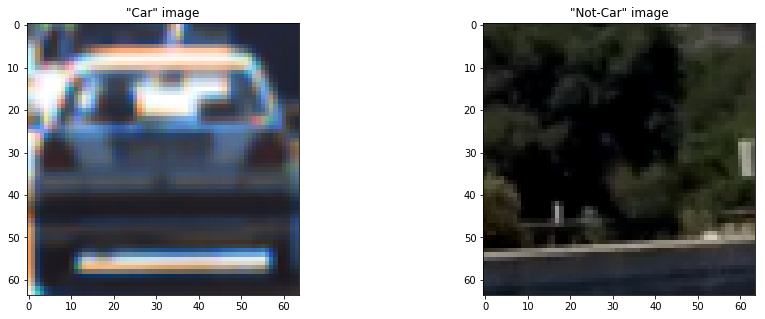

In [2]:
print("Retrieving non-vehicle image files... ",end='')
notcars = []
for dirName, subdirList, fileList in os.walk("./datasets/non-vehicles"):
    for fname in fileList:
        if fname.endswith('.png'):
            notcars.append(os.path.join(dirName,fname))
print("DONE! ",len(notcars),"images found.")
print("Retrieving vehicle image files...",end='')
cars = []
for dirName, subdirList, fileList in os.walk("./datasets/vehicles"):
    for fname in fileList:
        if fname.endswith('.png'):
            cars.append(os.path.join(dirName,fname))
print("DONE!      ",len(cars),"images found.")


# Function to help plotting multiple images
def multiplot(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
        else:
            plt.imshow(img)
        plt.title(titles[i])

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in example image
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

# Read in some attributes of data set and plot information
dataset = data_look(cars,notcars)

# Read in a car test image
example_img_car = mpimg.imread(cars[np.random.randint(0,dataset["n_cars"]-1)])
# Read in a not-car test image
example_img_notcar = mpimg.imread(notcars[np.random.randint(0,dataset["n_cars"]-1)])


fig = plt.figure(figsize=(15,5))
multiplot(fig, 1, 2, [example_img_car,example_img_notcar], ['"Car" image', '"Not-Car" image'])
plt.savefig('output_images/car_notcar_example.png',bbox_inches='tight')

## Helper functions

In [3]:
# Extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, vis=False, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, 
                        spatial_feat=True, hist_feat = True, hog_feat = True, 
                        hist_bins = 32, spatial_size=(32,32), transform_sqrt = False, block_norm = 'L2-Hys'):
    # Create a list to append feature vectors to
    features = []
#     # Then create a FloatProgress object with the relevant min and max values and 
#     # display it below the selected cell:
#     f = FloatProgress(min=0, max=len(imgs))
#     display(f)
    # Iterate through the list of images
    for file in tqdm(imgs):
        # Read in each one by one
        image = mpimg.imread(file)
        
        # apply color conversion if other than 'RGB'
        feature_image = color_conversion(image, cspace)
        
        ### Prepare feature array for individual file
        file_features = []
        
        ### Hog features: process, if switch was set to true
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            hog_features = []
            if hog_channel == 'ALL':
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True,
                                        trans_sqrt=transform_sqrt, block_nrm = block_norm))
                hog_features = np.ravel(hog_features)        
            else:
                if ((len(imgs) == 1) & (vis == True)):
                    hog_features,hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=True, feature_vec=True,
                            trans_sqrt=transform_sqrt, block_nrm = block_norm)
                else:
                    hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True,
                            trans_sqrt=transform_sqrt, block_nrm = block_norm)

            # Append the new feature vector to the features list
            file_features.append(hog_features)

        ### Spatial features: process, if switch was set to true
        if spatial_feat == True:
            spatial_features = get_spatial_features(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        
        ### Histogram features: process, if switch was so to true
        if hist_feat == True:
            hist_features = get_histogram_features(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        
        # Combine file_features and append to overall features array
        features.append(np.concatenate(file_features))
        
#         # Update progress bar
#         f.value += 1
    
    # 
    if ((len(imgs) == 1) & (vis == True)):
        return (features, hog_image)
    else:
        # Return list of feature vectors
        return features


def color_conversion(image, cspace='RGB'):
    # apply color conversion if other than 'RGB'
    # return converted image immediately
    if cspace != 'RGB':
        if cspace == 'HSV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            return cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: 
        return image 

    
def single_img_features(image, cspace='RGB', orient=9, vis=False, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, 
                        spatial_feat=True, hist_feat = True, hog_feat = True, 
                        hist_bins = 32, spatial_size=(32,32), transform_sqrt = False, block_norm = 'L2-Hys'):
    # apply color conversion if other than 'RGB'
    feature_image = color_conversion(image, cspace)

    ### Prepare feature array for individual file
    file_features = []

    ### Hog features: process, if switch was set to true
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        hog_features = []
        if hog_channel == 'ALL':
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True,
                                    trans_sqrt=transform_sqrt, block_nrm = block_norm))
            hog_features = np.ravel(hog_features)        
        else:
            if vis == True:
                hog_features,hog_image = get_hog_features(feature_image[:,:,0], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True,
                        trans_sqrt=transform_sqrt, block_nrm = block_norm)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True,
                        trans_sqrt=transform_sqrt, block_nrm = block_norm)

        # Append the new feature vector to the features list
        file_features.append(hog_features)

    ### Spatial features: process, if switch was set to true
    if spatial_feat == True:
        spatial_features = get_spatial_features(feature_image, size=spatial_size)
        file_features.append(spatial_features)

    ### Histogram features: process, if switch was so to true
    if hist_feat == True:
        hist_features = get_histogram_features(feature_image, nbins=hist_bins)
        file_features.append(hist_features)

    # Combine file_features and append to overall features array
    features = np.concatenate(file_features)

    if vis == True:
        return (features, hog_image)
    else:
        # Return list of feature vectors
        return features

    
# Return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True, block_nrm = 'L2-Hys', trans_sqrt = False):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img,
                                  orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= block_nrm,
                                  transform_sqrt=trans_sqrt, 
                                  visualize=vis,
                                  feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, 
                       orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= block_nrm,
                       transform_sqrt=trans_sqrt,
                       visualize=vis,
                       feature_vector=feature_vec)
        return features
    

# Return spatial features
def get_spatial_features(img, size=(32,32)):
    col1 = cv2.resize(img[:,:,0], size).ravel()
    col2 = cv2.resize(img[:,:,1], size).ravel()
    col3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((col1,col2,col3))


# Return histogram features
def get_histogram_features(img, nbins=32):
    hist_ch1 = np.histogram(img[:,:,0], bins=nbins)
    hist_ch2 = np.histogram(img[:,:,1], bins=nbins)
    hist_ch3 = np.histogram(img[:,:,2], bins=nbins)
    # Create single feature vector by concatenating channels
    return np.concatenate((hist_ch1[0], hist_ch2[0], hist_ch3[0]))

## Perform feature extraction & train SVM

In [4]:
# Reduce the sample size because HOG features are slow to compute
# sample_size = 1000
# cars = cars[0:sample_size]
# notcars = notcars[0:sample_size]

# Hyper-parameters
HP = namedtuple('HP', [], verbose=False);
HP.colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
HP.HOG_orient = 9 # 9
HP.pix_per_cell = 8
HP.cell_per_block = 2
HP.hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
HP.rand_state = 42   # Seed for random no generator (train_test_split) : needs to be set to "42" for obvious reasons
HP.hist_bins = 16
HP.spatial_size = (32,32)
HP.block_norm = 'L2-Hys'
HP.transform_sqrt = True
HP.use_spatial = True
HP.use_histogram = True
HP.use_hog = True

In [5]:
# Extract features
t0=time.time()
print('Extracting features from "car" data set...', flush=True)
car_features = extract_features(cars, 
                        cspace=HP.colorspace, orient=HP.HOG_orient, 
                        pix_per_cell=HP.pix_per_cell, cell_per_block=HP.cell_per_block, 
                        hog_channel=HP.hog_channel,spatial_feat=HP.use_spatial, hist_feat=HP.use_histogram, 
                        hog_feat=HP.use_hog,transform_sqrt = HP.transform_sqrt, 
                        block_norm = HP.block_norm, hist_bins=HP.hist_bins, spatial_size=HP.spatial_size)
print('Extracting features from "not-cars" data set...', flush=True)
notcar_features = extract_features(notcars, 
                        cspace=HP.colorspace, orient=HP.HOG_orient, 
                        pix_per_cell=HP.pix_per_cell, cell_per_block=HP.cell_per_block, 
                        hog_channel=HP.hog_channel,spatial_feat=HP.use_spatial, hist_feat=HP.use_histogram, 
                        hog_feat=HP.use_hog,transform_sqrt = HP.transform_sqrt, 
                        block_norm = HP.block_norm, hist_bins=HP.hist_bins, spatial_size=HP.spatial_size)


t1 = time.time()
print("-->",round(t1-t0, 2), 'Seconds to extract features...')


# Create an array stack of feature vectors (features: [n_pics, n_feature_length] --> v-stack (y-axis))
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=HP.rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)   # Define scaler only based on training dataset
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('\nUsing:',HP.HOG_orient,'orientations',HP.pix_per_cell,
    'pixels per cell and', HP.cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))




# Train linear SVC
svc = LinearSVC()
# Check the training time for the SVC
t2=time.time()
svc.fit(X_train, y_train)
t3 = time.time()
print("-->",round(t3-t2, 2), 's to train SVC...')
# Check the score of the SVC
print('-->', round(svc.score(X_test, y_test), 4)*100, '% Test Accuracy of SVC')

# Check the prediction time for a single sample
t4=time.time()
n_predict = 20
print('\nMy SVC predicts:     ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t5 = time.time()
print("-->",round((t5-t4)*1000, 2), 'ms to predict', n_predict,'labels with SVC')

Extracting features from "car" data set...

Extracting features from "not-cars" data set...

--> 212.16 Seconds to extract features...

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8412
--> 25.43 s to train SVC...
--> 99.21 % Test Accuracy of SVC

My SVC predicts:      [0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0.]
For these 20 labels:  [0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0.]
--> 3.7 ms to predict 20 labels with SVC


In [30]:
# Store Support Vector Machine data and Scaler to pickle file
print('Saving SVM and Scaler function to pickle file... ', end='')
datadump = {
    'svc': svc,
    'X_scaler': X_scaler,
    'colorspace': HP.colorspace,
    'orient': HP.HOG_orient,
    'pix_per_cell': HP.pix_per_cell,
    'cell_per_block': HP.cell_per_block,
    'hist_bins': HP.hist_bins,
    'spatial_size': HP.spatial_size,
    'block_norm': HP.block_norm,
    'transform_sqrt': HP.transform_sqrt    
    }
with open('./svm_scaler_result.pkl','wb') as f:
    pickle.dump(datadump,f)
print('DONE!')

Saving SVM and Scaler function to pickle file... DONE!


## Visualize example images including HOG image

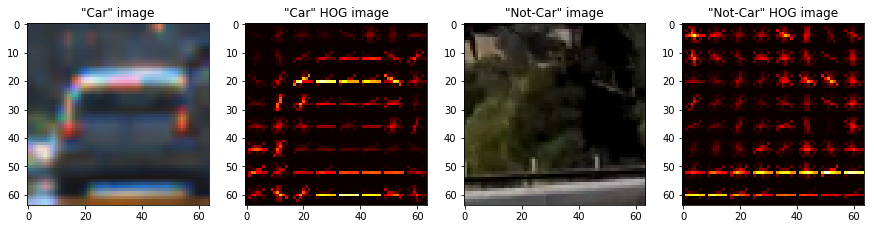

In [31]:
# car_file = cars[np.random.randint(0, len(cars))];
car_file = np.array([cars[np.random.randint(0, len(cars))]])
notcar_file = np.array([notcars[np.random.randint(0, len(notcars))]])

car_image = mpimg.imread(car_file.item(0))
_null, car_hog_image = single_img_features(car_image, 
                        cspace=HP.colorspace, orient=HP.HOG_orient, vis=True,
                        pix_per_cell=HP.pix_per_cell, cell_per_block=HP.cell_per_block, hog_channel=0, 
                        spatial_feat=HP.use_spatial, hist_feat=HP.use_histogram, hog_feat=HP.use_hog,
                        transform_sqrt = HP.transform_sqrt, block_norm = HP.block_norm)
notcars_image = mpimg.imread(notcars[np.random.randint(0, len(cars))])
_null, notcars_hog_image = single_img_features(notcars_image, 
                        cspace=HP.colorspace, orient=HP.HOG_orient, vis=True,
                        pix_per_cell=HP.pix_per_cell, cell_per_block=HP.cell_per_block, hog_channel=0, 
                        spatial_feat=HP.use_spatial, hist_feat=HP.use_histogram, hog_feat=HP.use_hog,
                        transform_sqrt = HP.transform_sqrt, block_norm = HP.block_norm)

fig = plt.figure(figsize=(15,5))
images = [car_image, car_hog_image, notcars_image,notcars_hog_image]
titles = ['"Car" image', '"Car" HOG image', '"Not-Car" image', '"Not-Car" HOG image']
multiplot(fig, 1, 4, images, titles)
plt.savefig('output_images/hog_feature_example.png',bbox_inches='tight')

## Visualize color histogram

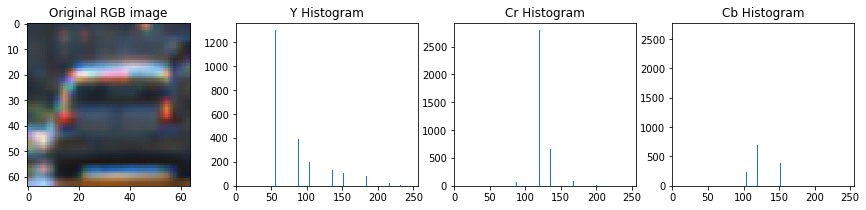

In [32]:
def visualize_color_histograms(img,nbins=16):
    # Convert to YCrCb color space
    img_cvt = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
#     img_cvt = np.copy(img)
    # Create histogram information for every channel
    hist_ch1 = np.histogram(img_cvt[:,:,0]*255, bins=nbins, range=(0, 256))
    hist_ch2 = np.histogram(img_cvt[:,:,1]*255, bins=nbins, range=(0, 256))
    hist_ch3 = np.histogram(img_cvt[:,:,2]*255, bins=nbins, range=(0, 256))
    # Generating bin centers
    bin_edges = hist_ch1[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Plot a figure with all three bar charts
    fig = plt.figure(figsize=(15,3))
    plt.subplot(141)
    plt.imshow(img)
    plt.title('Original RGB image')
    plt.subplot(142)
    plt.bar(bin_centers, hist_ch1[0])
    plt.xlim(0, 256)
    plt.title('Y Histogram')
    plt.subplot(143)
    plt.bar(bin_centers, hist_ch2[0])
    plt.xlim(0, 256)
    plt.title('Cr Histogram')
    plt.subplot(144)
    plt.bar(bin_centers, hist_ch3[0])
    plt.xlim(0, 256)
    plt.title('Cb Histogram')
    plt.savefig('output_images/color_hist_feature_example.png',bbox_inches='tight')
visualize_color_histograms(car_image)

# Part 2: Vehicle detection

## Further helper functions

In [33]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler,
                    color_space='RGB', 
                    spatial_size=(32, 32),
                    hist_bins=32, 
                    hist_range=(0, 256),
                    orient=9, 
                    pix_per_cell=8,
                    cell_per_block=2, 
                    hog_channel=0,
                    spatial_feat=True, 
                    hist_feat=True,
                    hog_feat=True,
                    transform_sqrt=True,
                    block_norm='L2-Hys'):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img,
                                       cspace=color_space,
                                       orient=orient, vis=False,
                                       pix_per_cell=pix_per_cell,
                                       cell_per_block=cell_per_block,
                                       hog_channel=hog_channel, 
                                       spatial_feat=spatial_feat,
                                       hist_bins = hist_bins,
                                       spatial_size = spatial_size,
                                       hist_feat=hist_feat,
                                       hog_feat=hog_feat,
                                       transform_sqrt = transform_sqrt,
                                       block_norm = block_norm)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy    

    
# Heat Map helper function
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
    
# Heat map threshold function
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


# Draw labeled boxes
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



## Read in test image files

In [34]:
# Read in all test images 
imgs = []
for root, dirs, files in os.walk("./test_images/"):
    for file in sorted(files):
        if file.endswith(".jpg"):
            # Read in images to list
            imgs.append(os.path.join(root,file))

13.357 seconds to process one image searching 1309 windows
14.745 seconds to process one image searching 1309 windows
14.493 seconds to process one image searching 1309 windows
13.489 seconds to process one image searching 1309 windows
13.612 seconds to process one image searching 1309 windows
14.276 seconds to process one image searching 1309 windows


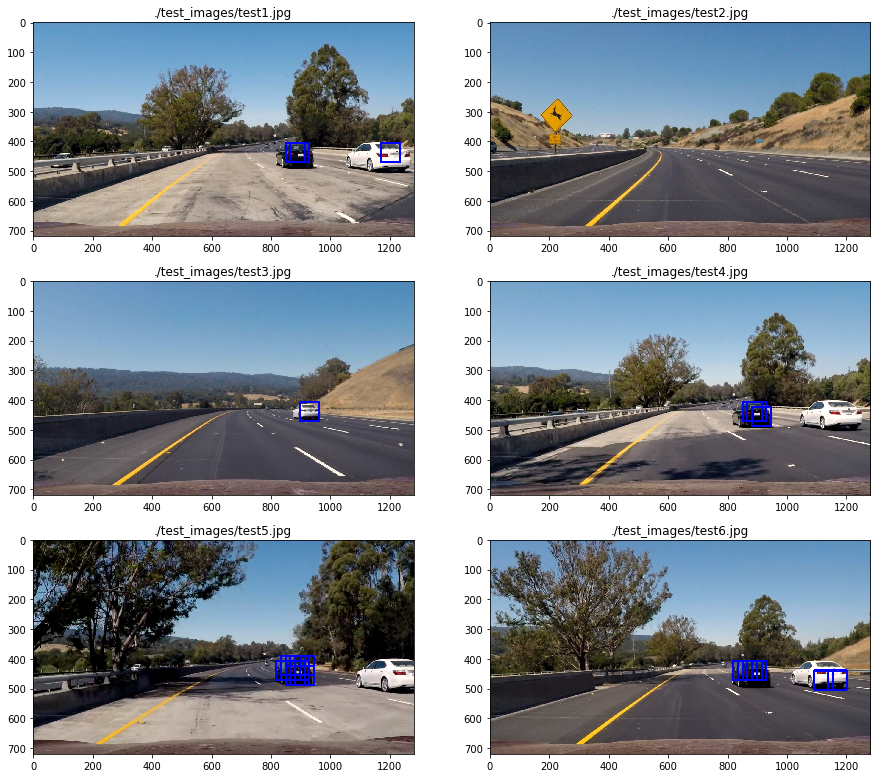

In [42]:
# Hyperparameters to tune
y_start_stop = [360,680] # Min and max in y to search in slide_window()

images = []
titles = []
for file in imgs:
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = mpimg.imread(file)
    draw_image = np.copy(image)
    image = image.astype(np.float32)/255
    
    t0 = time.time()
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64,64), xy_overlap=(0.75, 0.75))

    hot_windows = search_windows(image, windows, svc, X_scaler, 
                        color_space=HP.colorspace, 
                        spatial_size=HP.spatial_size,
                        hist_bins=HP.hist_bins, 
                        orient=HP.HOG_orient,
                        pix_per_cell=HP.pix_per_cell, 
                        cell_per_block=HP.cell_per_block, 
                        transform_sqrt=HP.transform_sqrt,
                        block_norm=HP.block_norm,
                        hog_channel=HP.hog_channel,         
                        spatial_feat=HP.use_spatial, 
                        hist_feat=HP.use_histogram,
                        hog_feat=HP.use_hog)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    images.append(window_img)
    titles.append(file)
    print(round(time.time()-t0, 3), "seconds to process one image searching", len(windows),'windows')
fig = plt.figure(figsize=(15,23))
multiplot(fig, 5, 2, images, titles)
plt.savefig('output_images/final_vehicle_detection.png',bbox_inches='tight') # TODO: save figure test

## Speed improvement
```
HP = namedtuple('HP', [], verbose=False);
HP.colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
HP.HOG_orient = 9 # 9
HP.pix_per_cell = 8
HP.cell_per_block = 2
HP.hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
HP.rand_state = 42   # Seed for random no generator (train_test_split), set to "42" for obvious reasons
HP.hist_bins = 16
HP.spatial_size = (32,32)
HP.transform_sqrt = True
HP.block_norm = 'L2-Hys'
HP.use_spatial = True
HP.use_histogram = True
HP.use_hog = True
```

0.67 seconds to run, total windows =  288
0.69 seconds to run, total windows =  288
0.69 seconds to run, total windows =  288
0.66 seconds to run, total windows =  288
0.68 seconds to run, total windows =  288
0.69 seconds to run, total windows =  288


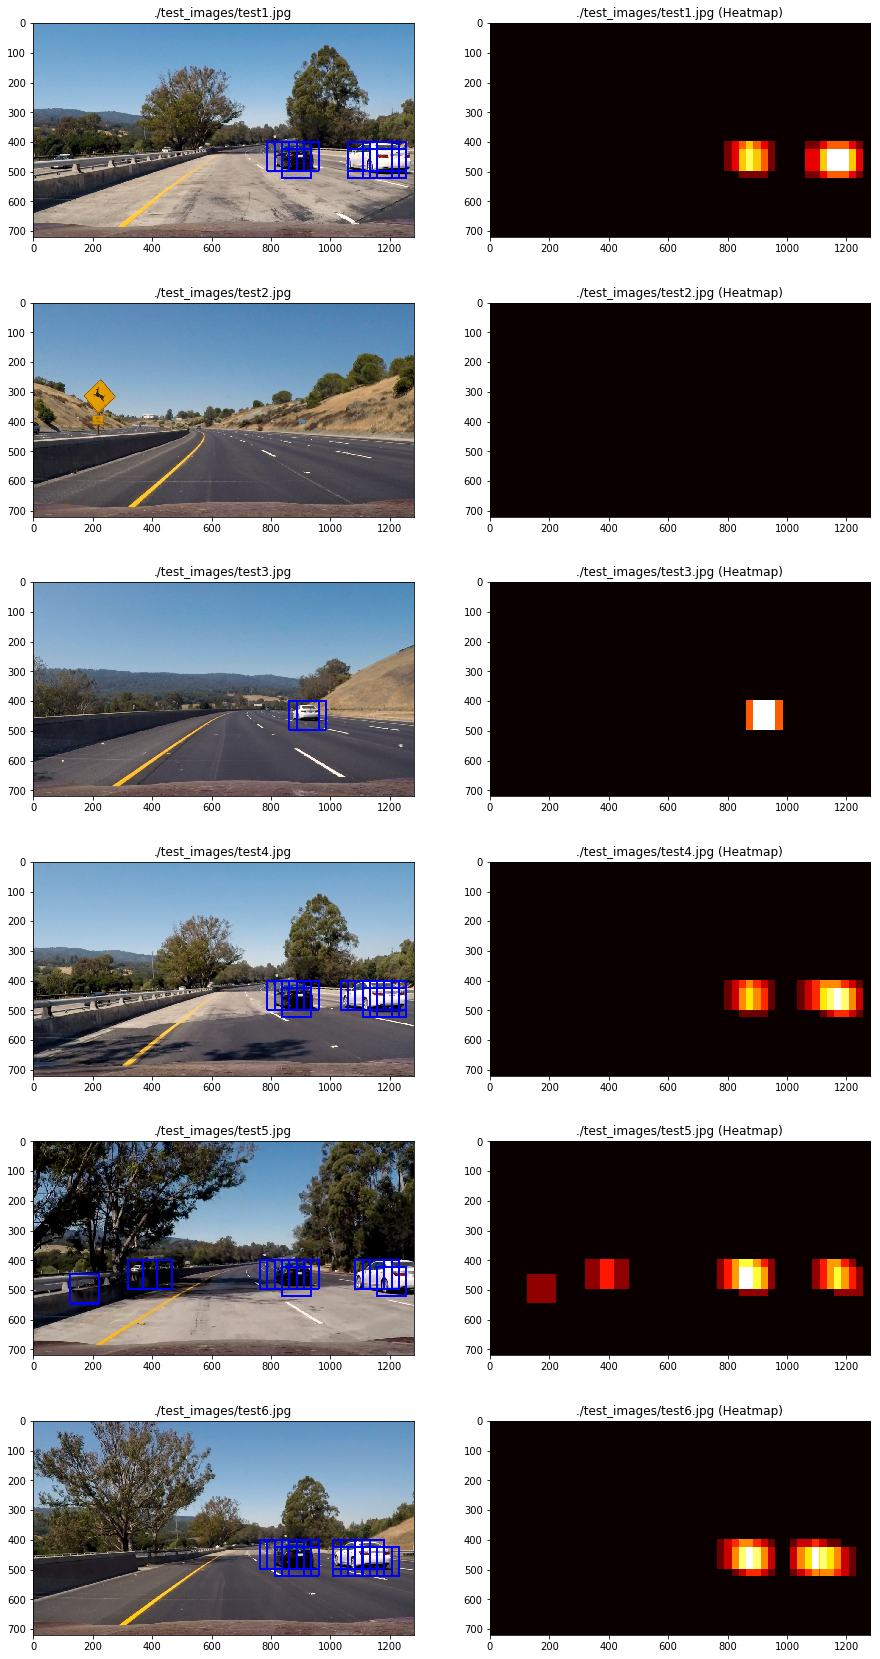

In [43]:
# Define further parameters to tune
HP.y_lim = [400,656] # Limit area in y to restrict analysis to relevant areas and speed up process
HP.scale = 1.538
HP.cells_per_step = 2 # Amount of cells to step (instead of overlap)

def detect_cars(img,HP,svc,X_scaler,scale):
    # Initialize variables
    count = 0
    img_boxes = []
    window = 64 # Original window size
    # Prepare output image and heatmap variables
    
    draw_img = np.copy(img)
    draw_img2 = np.copy(img)
    heatmap = np.zeros_like(img[:,:,0])
    # Have it scaled appropriately to have colorspace match the png training data
    img = img.astype(np.float32)/255
    
    # Reduce search area
    img_sub = img[HP.y_lim[0]:HP.y_lim[1],:,:]
    
    # apply color conversion if other than 'RGB' is desired
    img_sub = color_conversion(img_sub, HP.colorspace)
    
    # Scale image
    if scale != 1:
        imshape = img_sub.shape
        img_s_scld = cv2.resize(img_sub, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        #print("Scaled sub image from shape",imshape,"to",img_s_scld.shape)
    else:
        img_s_scld = np.copy(img_sub)
    imshape = img_s_scld.shape

    # Define blocks and steps
    nxblocks = (imshape[1] // HP.pix_per_cell) - 1
    nyblocks = (imshape[0] // HP.pix_per_cell) - 1
    nfeat_per_block = HP.HOG_orient*HP.cell_per_block**2
    
    nblocks_per_window = (window // HP.pix_per_cell) - 1
    nxsteps = (nxblocks - nblocks_per_window) // HP.cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // HP.cells_per_step
    
    # Calculate hog channels for the entire scaled sub image
    hog1 = get_hog_features(img_s_scld[:,:,0], HP.HOG_orient, HP.pix_per_cell, HP.cell_per_block, feature_vec=False)
    hog2 = get_hog_features(img_s_scld[:,:,1], HP.HOG_orient, HP.pix_per_cell, HP.cell_per_block, feature_vec=False)
    hog3 = get_hog_features(img_s_scld[:,:,2], HP.HOG_orient, HP.pix_per_cell, HP.cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb*HP.cells_per_step
            xpos = xb*HP.cells_per_step
            hogfeat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hogfeat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hogfeat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hogfeat1,hogfeat2,hogfeat3))
    
            xleft = xpos*HP.pix_per_cell
            ytop = ypos*HP.pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(img_s_scld[ytop:ytop+window, xleft:xleft+window],(64,64))
            
            # Get color features
            spatial_features = get_spatial_features(subimg, size=HP.spatial_size)
            hist_features = get_histogram_features(subimg, nbins=HP.hist_bins)
            
            # Scale features and make a prediction
            all_features = np.hstack((hog_features,spatial_features, hist_features))
            
            test_features = X_scaler.transform(all_features.reshape(1,-1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,
                              (xbox_left,ytop_draw+HP.y_lim[0]),
                              (xbox_left+win_draw,ytop_draw+win_draw+HP.y_lim[0]),
                              (0,0,255),
                              6)
                img_boxes.append(((xbox_left,ytop_draw+HP.y_lim[0]),(xbox_left+win_draw,ytop_draw+win_draw+HP.y_lim[0])))
                heatmap[ytop_draw+HP.y_lim[0]:ytop_draw+win_draw+HP.y_lim[0], xbox_left:xbox_left+win_draw] += 1

            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            cv2.rectangle(draw_img2,
                          (xbox_left,ytop_draw+HP.y_lim[0]),
                          (xbox_left+win_draw,ytop_draw+win_draw+HP.y_lim[0]),
                          (np.random.randint(0,255),np.random.randint(0,255),np.random.randint(0,255)),
                          6)

    return (draw_img,heatmap,img_boxes,count,draw_img2)
                
# Prepare variables and process sample images
out_images = []
out_titles = []
out_maps = []
out_boxes = []
for file in imgs:
    # Read jpg image
    img = mpimg.imread(file)
    # Start time counter to measure performance
    t0 = time.time()
    
    # Call vehicle detection function
    draw_img, heatmap, img_boxes, count, draw_img2 = detect_cars(img,HP,svc,X_scaler,HP.scale)
    
    # Print runtime
    print(round(time.time()-t0,2),'seconds to run, total windows = ',count)
    
    # Prepare image output
    out_images.append(draw_img)
    out_titles.append(file)
    out_images.append(heatmap)
    out_titles.append(file+" (Heatmap)")
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)
    

fig = plt.figure(figsize=(15,30))
multiplot(fig, 6, 2, out_images, out_titles)

## Analyse heat maps

5.13 seconds to run, total windows =  2274 . Max heat value:  39.0
5.05 seconds to run, total windows =  2274 . Max heat value:  0.0
5.16 seconds to run, total windows =  2274 . Max heat value:  6.0
5.08 seconds to run, total windows =  2274 . Max heat value:  40.0
5.03 seconds to run, total windows =  2274 . Max heat value:  30.0
5.34 seconds to run, total windows =  2274 . Max heat value:  40.0


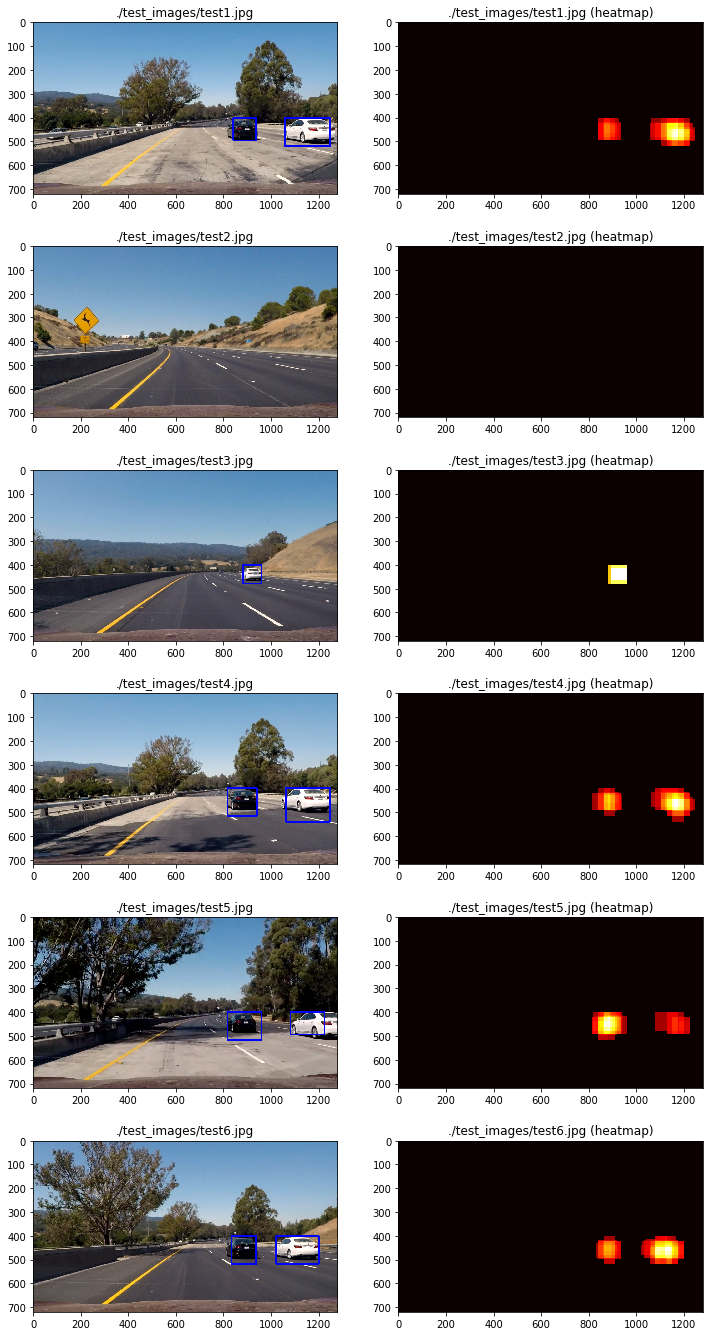

In [50]:
## from scipy.ndimage.measurements import label

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

out_images = []
out_titles = []
out_maps = []
ystart = HP.y_lim[0]
ystop = HP.y_lim[1]
scale = [1, 1.2500, 1.500, 1.8125, 2.2188]

for file in imgs:
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = mpimg.imread(file)
    t0 = time.time()
    draw_img1, heatmap1, img_boxes1, count1, draw_img1_2 = detect_cars(image.astype(np.float32)/255,HP,svc,X_scaler,scale[0])
    draw_img2, heatmap2, img_boxes2, count2, draw_img2_2 = detect_cars(image.astype(np.float32)/255,HP,svc,X_scaler,scale[1])
    draw_img3, heatmap3, img_boxes3, count3, draw_img3_2 = detect_cars(image.astype(np.float32)/255,HP,svc,X_scaler,scale[2])
    draw_img4, heatmap4, img_boxes4, count4, draw_img4_2 = detect_cars(image.astype(np.float32)/255,HP,svc,X_scaler,scale[2])
    draw_img5, heatmap5, img_boxes5, count5, draw_img5_2 = detect_cars(image.astype(np.float32)/255,HP,svc,X_scaler,scale[2])


    heatmap = heatmap1+heatmap2+heatmap3+heatmap4+heatmap5
    heatmap = apply_threshold(heatmap, np.max(heatmap)*0.2)
    heatmap = apply_threshold(heatmap, 3)
    count = count1+count2+count3+count4+count5
    # Detect labels for individual vehicles
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image),labels)
    out_images.append(draw_img)
    out_titles.append(file)
    out_images.append(heatmap)
    out_titles.append(file+" (heatmap)")
    # Print runtime
    print(round(time.time()-t0,2),'seconds to run, total windows = ',count,". Max heat value: ",np.max(heatmap))


    
fig = plt.figure(figsize=(12,24))
multiplot(fig, 6, 2, out_images, out_titles)
plt.savefig('output_images/heatmaps_labels_bounding_boxes.png',bbox_inches='tight') # TODO: save figure test
# TODO: hier weitermachen

In [ ]:
def process_image(image):
    global buffer
    draw_img1, heatmap1, img_boxes1, count1, draw_img1_2 = detect_cars(image.astype(np.float32)/255,HP,svc,X_scaler,scale[0])
    draw_img2, heatmap2, img_boxes2, count2, draw_img2_2 = detect_cars(image.astype(np.float32)/255,HP,svc,X_scaler,scale[1])
    draw_img3, heatmap3, img_boxes3, count3, draw_img3_2 = detect_cars(image.astype(np.float32)/255,HP,svc,X_scaler,scale[2])
    heatmap = heatmap1+heatmap2+heatmap3
#     heatmap[heatmap<2] = 0
    # Store heatmap in double ended queue buffer, calculate averaged heatmap over 10 frames (i.e. buffer size)
    buffer.append(heatmap)
    heatmap_avg = np.average(buffer,0)
    heatmap_avg[heatmap_avg<3] = 0
    # Detect labels for individual vehicles
    labels = label(heatmap_avg)
    return draw_labeled_bboxes(np.copy(image),labels)

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque

# Initialize buffer for heatmap, define it as global variable
buffer = deque(maxlen=10)
global buffer

# Process video file
test_output = 'test.mp4'
# clip = VideoFileClip('test_video.mp4')
clip = VideoFileClip('project_video.mp4')
test_clip = clip.fl_image(process_image)
test_clip.write_videofile(test_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))